In [77]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

### Data preprocessing

In [78]:
# Read training data from train.csv
data=pd.read_csv("data/train.csv",encoding='big5')

In [79]:
# skip unnecessary columns
data=data.iloc[:,3:]

In [80]:
# wash data
data[data=='NR']=0
raw_data=data.to_numpy()

### Feature Engineering

In [81]:
# extract features 1.0
# group by month,12 months in total
# 20 days a month, 24 hours a day
# the feature matrix has the size of 18*480

# create feature map
month_data={}
for month in range(12):
    ft=np.empty([18,480])
    # 20*month+day represents the NO. of day
    # a day has a dimension of 24 hours
    # a day contains a record of 18 features
    for day in range(20):
        ft[:,day*24:(day+1)*24]=raw_data[18*(20*month+day):18*(20*month+day+1),:]
    month_data[month]=ft

In [82]:
# extract features 2.0
x=np.empty([12*471,18*9],dtype=float)
y=np.empty([12*471,1],dtype=float)
for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day==19 and hour>14:
                continue
            x[month*471+day*24+hour,:]=month_data[month][:,day*24+hour:day*24+hour+9].reshape(1,-1) #18*9
            y[month*471+day*24+hour,0]=month_data[month][9,day*24+hour+9] # value for PM2.5 of the 10th hour

In [83]:
# normalize
mean_x=np.mean(x,axis=0)# 18*9
std_x=np.std(x,axis=0)# 18*9
for i in range(len(x)):# 12*471
    for j in range (len(x[0])):#18*9
        if std_x[j]!=0:
            x[i][j]=(x[i][j]-mean_x[j])/std_x[j]

In [84]:
# split set
x_train=x[:math.floor(0.8*len(x)),:]
y_train=y[:math.floor(0.8*len(y)),:]

x_val=x[math.floor(0.8*len(x)):,:]
y_val=y[math.floor(0.8*len(y)):,:]

###  Training

In [85]:
# hyper parameters
lr=0.1
iteration=30000

##### 1.Gradient descent

In [86]:
def GD(x_train,y_train,iteration,lr):
    dim=18*9+1 # the dim of features
    w=np.zeros([dim,1])
    x_train=np.concatenate((np.ones([len(x_train),1]),x_train),axis=1).astype(float) #(len(x_train)*dim)
    loss_store=[]
    for t in range(iteration):
        loss=np.dot(x_train,w)-y_train
        cost=np.sum(loss**2)/x_train.shape[0]
        loss_store.append(cost)
        if t%10==0:
            print(str(t)+":"+str(cost))
        gradient=2*np.dot(x_train.transpose(),loss)/x_train.shape[0] # (dim,batch_size)*(batch_size,1)
        w=w-lr*gradient
    return w,loss_store

###### 2.Adagrad

In [87]:
def Adagrad(x_train,y_train,x_val,y_val,iteration,lr):
    dim=18*9+1
    w=np.zeros([dim,1])
    x_train=np.concatenate((np.ones([len(x_train),1]),x_train),axis=1).astype(float)
    x_val=np.concatenate((np.ones([len(x_val),1]),x_val),axis=1).astype(float)
    adagrad=np.zeros([dim,1])
    eps=1e-9
    loss_store=[]
    loss_val=[]
    for t in range(iteration):
        loss=np.dot(x_train,w)-y_train
        loss1=np.dot(x_val,w)-y_val
        cost=np.sum(loss**2)/x_train.shape[0]
        cost1=np.sum(loss1**2)/x_val.shape[0]
        if t%10==0:
            print(str(t)+":"+str(cost))
        gradient=2*np.dot(x_train.transpose(),loss) # (dim,batch_size)*(batch_size,1)
        adagrad+=gradient**2
        w=w-lr*gradient/np.sqrt(adagrad+eps)
        loss_store.append(cost)
        loss_val.append(cost1)
    return w,loss_store,loss_val

##### 3.Stochastic Gradient Descent

In [88]:
def SGD(x_train,y_train,iteration,lr):
    dim=18*9+1 # the dim of features
    w=np.zeros([dim,1])
    x_train=np.concatenate((np.ones([len(x_train),1]),x_train),axis=1).astype(float) #(len(x_train)*dim)
    loss_store=[]
    for t in range(iteration):
        loss=np.dot(x_train,w)-y_train
        cost=np.sum(loss**2)/x_train.shape[0]
        loss_store.append(cost)
        if t%10==0:
            print(str(t)+":"+str(cost))
        rand=np.random.randint(0,x_train.shape[0])
        gradient=2*x_train[rand]*loss[rand]/x_train.shape[0]
        w=w-lr*gradient
    return w,loss_store

In [89]:
w_ada,loss_ada,loss_val=Adagrad(x_train,y_train,x_val,y_val,iteration,lr)
#w_gd,loss_gd=GD(x_train,y_train,iteration,lr)
#w_sgd,loss_sgd=SGD(x_train,y_train,iteration,lr)

0:741.9953550099535
10:548.0137286566194
20:520.6139559245639
30:503.63884757905174
40:491.1037744548239
50:481.0198710458584
60:472.497736394953
70:465.0661603452145
80:458.4450028279046
90:452.4532163692641
100:446.96630262034205
110:441.89453727508703
120:437.1708793612085
130:432.7437926879336
140:428.57274122056924
150:424.6252306377834
160:420.87479141990696
170:417.2995610210231
180:413.8812615836567
190:410.6044470124656
200:407.4559382910355
210:404.42439325930565
220:401.4999742433241
230:398.67408805619567
240:395.9391802914371
250:393.28857086752777
260:390.71632127846226
270:388.2171264729291
280:385.78622605292117
290:383.41933076634956
300:381.1125612114252
310:378.8623963710633
320:376.66563012096657
330:374.5193342527659
340:372.42082685724256
350:370.3676451463691
360:368.3575219741582
370:366.3883654579171
380:364.4582412128927
390:362.56535680151285
400:360.7080480687342
410:358.884767091391
420:357.094071514922
430:355.33461508775576
440:353.6051392337401
450:351.9

3610:156.03519220633427
3620:155.75497076650603
3630:155.47562424193168
3640:155.19714845818567
3650:154.9195392705475
3660:154.64279256371273
3670:154.3669042515078
3680:154.09187027660872
3690:153.8176866102622
3700:153.5443492520117
3710:153.27185422942566
3720:153.00019759782933
3730:152.72937544004046
3740:152.4593838661073
3750:152.1902190130503
3760:151.9218770446071
3770:151.65435415098025
3780:151.387646548588
3790:151.1217504798181
3800:150.85666221278473
3810:150.59237804108832
3820:150.32889428357785
3830:150.06620728411667
3840:149.8043134113501
3850:149.54320905847666
3860:149.28289064302177
3870:149.02335460661405
3880:148.7645974147636
3890:148.5066155566445
3900:148.24940554487787
3910:147.9929639153191
3920:147.73728722684646
3930:147.48237206115277
3940:147.22821502253913
3950:146.97481273771123
3960:146.72216185557787
3970:146.47025904705197
3980:146.2191010048534
3990:145.96868444331474
4000:145.7190060981888
4010:145.47006272645837
4020:145.22185110614794
4030:144

7130:92.61997542551737
7140:92.5061536688576
7150:92.39258202836407
7160:92.27925980797129
7170:92.16618631423412
7180:92.0533608563149
7190:91.94078274597004
7200:91.82845129753707
7210:91.71636582792196
7220:91.60452565658575
7230:91.49293010553204
7240:91.38157849929418
7250:91.27047016492257
7260:91.1596044319724
7270:91.04898063249064
7280:90.93859810100416
7290:90.82845617450715
7300:90.71855419244886
7310:90.60889149672148
7320:90.49946743164811
7330:90.39028134397067
7340:90.28133258283783
7350:90.17262049979345
7360:90.06414444876458
7370:89.95590378604973
7380:89.84789787030726
7390:89.74012606254396
7400:89.6325877261032
7410:89.5252822266539
7420:89.41820893217879
7430:89.31136721296349
7440:89.20475644158508
7450:89.0983759929009
7460:88.99222524403757
7470:88.88630357438008
7480:88.78061036556059
7490:88.67514500144775
7500:88.56990686813583
7510:88.46489535393394
7520:88.36010984935552
7530:88.25554974710744
7540:88.15121444207962
7550:88.04710333133471
7560:87.943215814

10690:63.99173673117653
10700:63.93651153952448
10710:63.88139159540604
10720:63.8263766704038
10730:63.77146653670561
10740:63.716660967102015
10750:63.661959734984435
10760:63.607362614343295
10770:63.55286937976553
10780:63.49847980643303
10790:63.444193670120534
10800:63.390010747193195
10810:63.33593081460542
10820:63.28195364989807
10830:63.228079031197005
10840:63.17430673721099
10850:63.12063654722962
10860:63.067068241121525
10870:63.013601599332375
10880:62.96023640288292
10890:62.90697243336715
10900:62.853809472950225
10910:62.80074730436677
10920:62.74778571091887
10930:62.694924476474235
10940:62.642163385464066
10950:62.5895022228817
10960:62.5369407742802
10970:62.48447882577078
10980:62.43211616402112
10990:62.37985257625296
11000:62.32768785024089
11010:62.27562177431023
11020:62.22365413733517
11030:62.17178472873692
11040:62.12001333848226
11050:62.06833975708131
11060:62.01676377558595
11070:61.96528518558806
11080:61.913903779217684
11090:61.86261934914139
11100:6

14160:49.86183778151728
14170:49.832657541330896
14180:49.8035292990119
14190:49.77445295469523
14200:49.74542840873264
14210:49.71645556169238
14220:49.68753431435829
14230:49.658664567729616
14240:49.629846223020124
14250:49.601079181657724
14260:49.57236334528385
14270:49.54369861575297
14280:49.51508489513191
14290:49.486522085699505
14300:49.45801008994591
14310:49.42954881057194
14320:49.401138150488784
14330:49.37277801281736
14340:49.34446830088777
14350:49.31620891823856
14360:49.28799976861645
14370:49.25984075597595
14380:49.231731784478214
14390:49.20367275849119
14400:49.175663582588655
14410:49.147704161549804
14420:49.119794400358835
14430:49.09193420420412
14440:49.06412347847818
14450:49.03636212877662
14460:49.008650060898006
14470:48.98098718084308
14480:48.953373394814456
14490:48.92580860921597
14500:48.89829273065214
14510:48.87082566592785
14520:48.84340732204767
14530:48.816037606215296
14540:48.78871642583318
14550:48.76144368850196
14560:48.734219302020065
145

17700:42.166909680702766
17710:42.15119090025274
17720:42.135499097958075
17730:42.11983422534884
17740:42.104196234048736
17750:42.08858507577505
17760:42.07300070233849
17770:42.05744306564268
17780:42.04191211768443
17790:42.026407810553174
17800:42.010930096430855
17810:41.99547892759177
17820:41.98005425640231
17830:41.96465603532084
17840:41.94928421689745
17850:41.933938753773724
17860:41.918619598682625
17870:41.90332670444824
17880:41.888060023985496
17890:41.87281951030025
17900:41.857605116488784
17910:41.84241679573764
17920:41.82725450132368
17930:41.81211818661362
17940:41.797007805064005
17950:41.781923310220876
17960:41.76686465571972
17970:41.751831795285156
17980:41.73682468273078
17990:41.72184327195909
18000:41.70688751696108
18010:41.69195737181621
18020:41.67705279069216
18030:41.662173727844525
18040:41.64732013761698
18050:41.63249197444071
18060:41.61768919283438
18070:41.602911747403965
18080:41.588159592842494
18090:41.5734326839299
18100:41.55873097553285
18

21220:38.00233842220257
21230:37.99368845115869
21240:37.98505298831446
21250:37.976432008557914
21260:37.96782548682249
21270:37.959233398087115
21280:37.95065571737594
21290:37.942092419758346
21300:37.933543480348845
21310:37.92500887430703
21320:37.91648857683737
21330:37.907982563189236
21340:37.899490808656765
21350:37.89101328857883
21360:37.88254997833881
21370:37.87410085336468
21380:37.86566588912885
21390:37.85724506114798
21400:37.84883834498305
21410:37.84044571623922
21420:37.83206715056571
21430:37.82370262365579
21440:37.81535211124654
21450:37.807015589118954
21460:37.79869303309774
21470:37.79038441905123
21480:37.78208972289137
21490:37.77380892057361
21500:37.76554198809677
21510:37.75728890150296
21520:37.749049636877594
21530:37.7408241703492
21540:37.7326124780894
21550:37.72441453631277
21560:37.71623032127678
21570:37.70805980928177
21580:37.699902976670735
21590:37.6917597998294
21600:37.683630255186
21610:37.675514319211324
21620:37.667411968418506
21630:37.6

24710:35.71246611630868
24720:35.707627213517114
24730:35.702796293862725
24740:35.69797334383435
24750:35.693158349944234
24760:35.688351298728314
24770:35.683552176745835
24780:35.678760970579624
24790:35.673977666835796
24800:35.669202252143826
24810:35.66443471315657
24820:35.65967503655004
24830:35.65492320902354
24840:35.65017921729954
24850:35.64544304812362
24860:35.64071468826448
24870:35.63599412451386
24880:35.6312813436865
24890:35.62657633262012
24900:35.6218790781754
24910:35.61718956723582
24920:35.61250778670778
24930:35.607833723520436
24940:35.60316736462575
24950:35.598508696998316
24960:35.59385770763548
24970:35.5892143835572
24980:35.584578711805975
24990:35.579950679446966
25000:35.575330273567786
25010:35.57071748127849
25020:35.56611228971158
25030:35.561514686022
25040:35.55692465738697
25050:35.55234219100607
25060:35.54776727410109
25070:35.543199893916075
25080:35.53864003771731
25090:35.53408769279317
25100:35.52954284645409
25110:35.52500548603263
25120:3

28220:34.42080901036364
28230:34.418087122829526
28240:34.41536966146486
28250:34.41265661889253
28260:34.409947987748005
28270:34.40724376067925
28280:34.40454393034682
28290:34.40184848942373
28300:34.39915743059551
28310:34.39647074656013
28320:34.39378843002798
28330:34.391110473721966
28340:34.38843687037729
28350:34.38576761274159
28360:34.38310269357483
28370:34.38044210564931
28380:34.377785841749656
28390:34.37513389467279
28400:34.37248625722787
28410:34.36984292223632
28420:34.36720388253177
28430:34.36456913096009
28440:34.36193866037932
28450:34.35931246365964
28460:34.35669053368338
28470:34.35407286334499
28480:34.35145944555104
28490:34.348850273220144
28500:34.34624533928298
28510:34.34364463668227
28520:34.34104815837271
28530:34.33845589732106
28540:34.335867846506005
28550:34.333283998918155
28560:34.33070434756011
28570:34.328128885446304
28580:34.325557605603144
28590:34.322990501068816
28600:34.320427564893436
28610:34.31786879013887
28620:34.31531416987883
28630

In [90]:
np.save('data/w_ada.npy',w_ada)
#np.save('w_sgd.npy',w_sgd)
#np.save('w_gd.npy',w_gd)

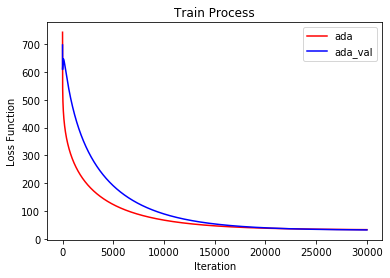

In [91]:
plt.plot(np.arange(len(loss_ada)), loss_ada,'r', label="ada")
plt.plot(np.arange(len(loss_val)), loss_val,'b', label="ada_val")
plt.title('Train Process')
plt.xlabel('Iteration')
plt.ylabel('Loss Function')
plt.legend()
plt.show()

### Evaluating

In [94]:
# preprocess test_data like train_data
test_data=pd.read_csv('data/test.csv',header=None,encoding='big5')
test_data=test_data.iloc[:,2:]
test_data[test_data=='NR']=0
test_data=test_data.to_numpy()
test_x=np.empty([240,18*9],dtype=float)
for i in range(240):
    test_x[i,:]=test_data[18*i:18*(i+1),:].reshape(1,-1)
for i in range(len(test_x)):# 12*471
    for j in range (len(test_x[0])):#18*9
        if std_x[j]!=0:
            test_x[i][j]=(test_x[i][j]-mean_x[j])/std_x[j]
test_x=np.concatenate((np.ones([240,1]),test_x),axis=1).astype(float)
w=np.load('data/w_ada.npy')
pred_y=np.dot(test_x,w_ada)

In [95]:
import csv
with open('data/submit.csv', mode='w', newline='') as submit_file:
    csv_writer = csv.writer(submit_file)
    header = ['id', 'value']
    print(header)
    csv_writer.writerow(header)
    for i in range(240):
        row = ['id_' + str(i), pred_y[i][0]]
        csv_writer.writerow(row)
        print(row)

['id', 'value']
['id_0', 5.304565204400899]
['id_1', 16.438369362736143]
['id_2', 24.066957170435558]
['id_3', 5.419025792660746]
['id_4', 26.713428937094314]
['id_5', 21.212589874736615]
['id_6', 23.598575819361745]
['id_7', 30.583045179309835]
['id_8', 17.030308973810577]
['id_9', 58.27701757570776]
['id_10', 11.628785078865894]
['id_11', 8.844418358169403]
['id_12', 61.0033919104964]
['id_13', 53.19475105456033]
['id_14', 21.2744336114845]
['id_15', 10.43459098852688]
['id_16', 31.358064534126406]
['id_17', 65.53445553667311]
['id_18', -1.6656509221856624]
['id_19', 16.48870290377512]
['id_20', 40.868886254229054]
['id_21', 71.04239905111938]
['id_22', 7.785277222995123]
['id_23', 16.891803391346063]
['id_24', 13.86305049809909]
['id_25', 36.257761189223075]
['id_26', 13.61212256371889]
['id_27', 65.11898934820607]
['id_28', 6.611917356762065]
['id_29', 55.963677193991224]
['id_30', 23.500168017495348]
['id_31', 8.864717775602577]
['id_32', 2.06689790182682]
['id_33', 19.41818207095